[*********************100%***********************]  1 of 1 completed


Stock: TSLA | Volatility spikes detected : 209

Total Trades : 209
Average PnL : -0.30
Total PnL : -62.10
Winning Trades : 108 / 209


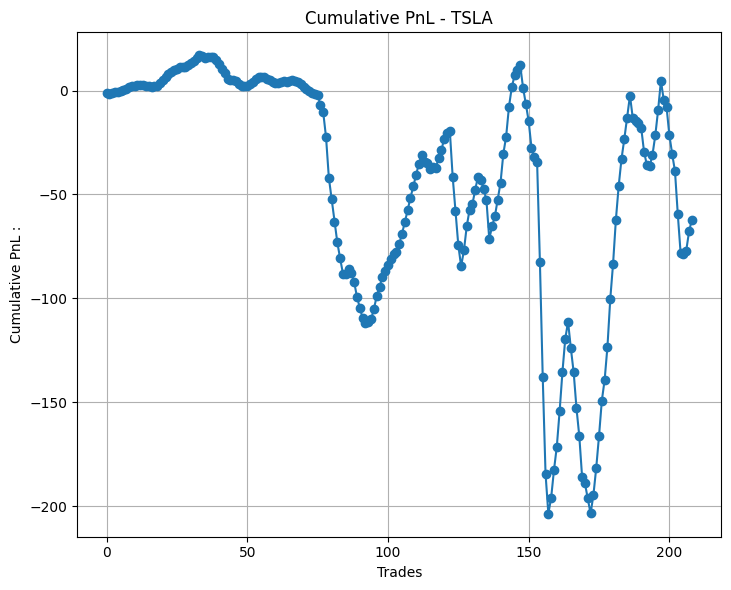

In [20]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes formula

def black_scholes_price(S, K, T, r, sigma, option_type='call'):
    
    if isinstance(S, pd.Series):
        S = S.iloc[0]
    if isinstance(K, pd.Series):
        K = K.iloc[0]
    if isinstance(sigma, pd.Series):
        sigma = sigma.iloc[0]

    S = float(S)
    K = float(K)
    T = float(T)
    r = float(r)
    sigma = float(sigma)

    if sigma <= 0 or T <= 0:
        return max(0.0, S - K) if option_type == 'call' else max(0.0, K - S)

    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    if option_type == 'call':
        price = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        price = K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

    return price

# Detecting volatility spikes

def detect_vol_spike(df, window=30, threshold=1.2):  # Threshold ( 20% spike as compared to rolling volumes ) 
    df['HV_30'] = df['Close'].pct_change().rolling(30).std() * np.sqrt(252)
    df['HV_30_MA'] = df['HV_30'].rolling(window).mean()
    df['Volatility_Spike'] = df['HV_30'] > (threshold * df['HV_30_MA'])
    return df

def backtest_vol_spike(stock, hold_days=7):
    df = yf.download(stock, start="2018-01-01", end="2024-01-01")
    df = detect_vol_spike(df)

    spike_dates = df.index[df['Volatility_Spike']]
    print(f"Stock: {stock} | Volatility spikes detected : {len(spike_dates)}")
    
    r = 0.02  # ( assuming 2% risk free return ) 
    initial_T = 30 / 365  # Assumng 30 days to expiry
    pnls = []

    for date in spike_dates:
        if date not in df.index:
            continue
        
        # Selling ATM Call on spike day ( delta 0.5 )
        
        try:
            S_sell = df.loc[date, 'Close']
            vol_sell = df.loc[date, 'HV_30']
        except KeyError:
            continue
        
        strike = S_sell  # ATM strike

        price_sell = black_scholes_price(S_sell, strike, initial_T, r, vol_sell, option_type='call')

        # Move forward hold_days ( 7 selected ) 
        
        future_idx = df.index.get_loc(date) + hold_days
        if future_idx >= len(df):
            continue
        
        future_date = df.index[future_idx]

        try:
            S_buy = df.loc[future_date, 'Close']
            vol_buy = df.loc[future_date, 'HV_30']
        except KeyError:
            continue

        remaining_T = (30 - hold_days) / 365

        price_buy = black_scholes_price(S_buy, strike, remaining_T, r, vol_buy, option_type='call')

        pnl = price_sell - price_buy
        pnls.append(pnl)

    return pnls



# ing

def report(pnls) : 
    print(f"\nTotal Trades : {len(pnls)}")
    print(f"Average PnL : {np.mean(pnls):.2f}")
    print(f"Total PnL : {np.sum(pnls):.2f}")
    print(f"Winning Trades : {np.sum(np.array(pnls) > 0)} / {len(pnls)}") 
    return 0  


# Cum. PnL

def plot(pnls) :
    cum_pnl = np.cumsum(pnls)

    plt.figure(figsize=(14,6))
    plt.subplot(1,2,1)
    plt.plot(cum_pnl, marker='o')
    plt.title(f'Cumulative PnL - {stock}')
    plt.xlabel('Trades')
    plt.ylabel('Cumulative PnL :')
    plt.grid()
    plt.tight_layout()
    plt.show()

stock = 'TSLA'
pnl = backtest_vol_spike(stock)
report(pnls)
plot(pnls)

[*********************100%***********************]  1 of 1 completed


Stock: NVDA | Volatility spikes detected : 215

Total Trades : 215
Average PnL : -0.01
Total PnL : -1.40
Winning Trades : 116 / 215


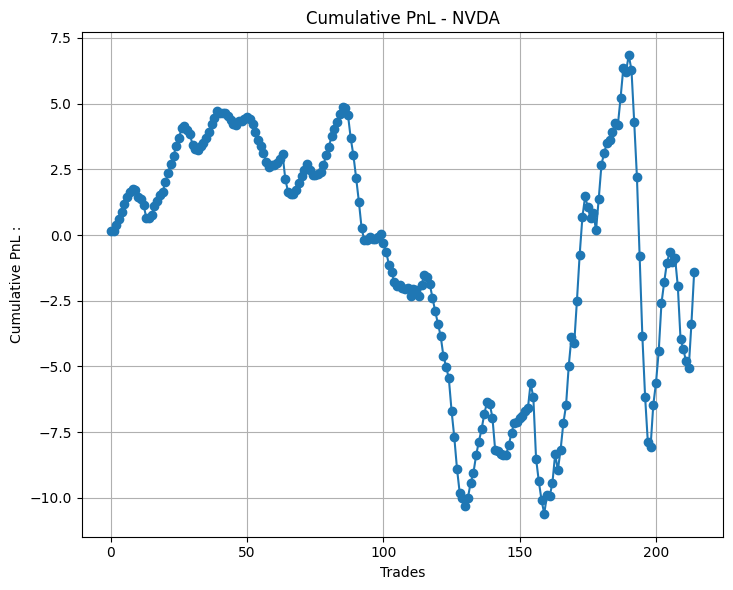

In [21]:
# Testing it for for Nvidia 
stock = 'NVDA'
pnl_1 = backtest_vol_spike(stock)
report(pnl_1)
plot(pnl_1)
